# Imports

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA Tesla K80'

In [3]:
import torch
import numpy as np
import os
import os.path as osp
import tqdm
import matplotlib.pylab as plt
from torch import nn
from torch import optim
from collections import defaultdict

## Imports based on our ready-to-use code (after you pip-install the cs233_gtda_hw4 package)
from cs233_gtda_hw4.in_out.utils import make_data_loaders
from cs233_gtda_hw4.in_out.utils import save_state_dicts, load_state_dicts
from cs233_gtda_hw4.in_out import pointcloud_dataset
from cs233_gtda_hw4.in_out.plotting import plot_3d_point_cloud


## Imports you might use if you follow are scaffold code (it is OK to use your own stucture of the models)
from cs233_gtda_hw4.models import PointcloudAutoencoder
from cs233_gtda_hw4.models import PartAwarePointcloudAutoencoder
from cs233_gtda_hw4.models.point_net import PointNet
from cs233_gtda_hw4.models.mlp import MLP
from cs233_gtda_hw4.models.part_classifier import part_classifier

%load_ext autoreload
%autoreload 2

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


In [4]:
##
## Fixed Settings (we do not expect you to change these)
## 

n_points = 1024  # number of points of each point-cloud
n_parts = 4      # max number of parts of each shape
n_train_epochs = 400

# Students: feel free to change below -ONLY- for the bonus Question:
# I.e., use THESE hyper-parameters when you train for the non-bonus questions.

part_lambda = 0.005  # for the part-aware AE you will be using (summing) two losses:
                     # chamfer + cross-entropy
                     # do it like this: chamfer + (part_lambda * cross-entropy), 
                     # i.e. we are scaling down the cross-entropy term
init_lr = 0.009  # initial learning-rate, tested by us with ADAM optimizer (see below)

In [5]:
## Students: feel free to change below:

# batch-size of data loaders
batch_size = 128 # if you can keep this too as is keep it, 
                 # but if it is too big for your GPU, feel free to change it.

# which device to use: cpu or cuda?
#device = 'cpu'     # Note: only the "alternative" (slower) chamfer_loss in losses/nn_distance can run in cpu.
device = 'cuda'

top_in_dir = '../data/'
top_out_dir = '../data/out/'
if not osp.exists(top_out_dir):
    os.makedirs(top_out_dir)

In [6]:
# PREPARE DATA:

loaders = make_data_loaders(top_in_dir, batch_size)

for split, loader in loaders.items():
    print('N-examples', split, len(loader.dataset))
    
# BUILD MODELS:
### TODO: Student on your own:
NUM_POINTS = 1024
NUM_CHANNELS = 3
LATENT_DIM = 128
# batch_size, num_channels, num_points

encoder = PointNet(NUM_CHANNELS)
decoder = MLP(LATENT_DIM, NUM_POINTS)
part_classifier = part_classifier(LATENT_DIM+NUM_CHANNELS, n_parts, 0.005)

N-examples train 750
N-examples test 150
N-examples val 50


## 1. Model

In [7]:
part_aware_model = False # or True

if part_aware_model:
    xentropy = nn.CrossEntropyLoss()
    model = PartAwarePointcloudAutoencoder(encoder, decoder, part_classifier, part_lambda).to(device) # Students Work here
    model_tag = 'part_pc_ae'
else:
    model = PointcloudAutoencoder(encoder, decoder).to(device)  # Students Work here
    model_tag = 'pc_ae'

In [8]:
print(model)

PointcloudAutoencoder(
  (encoder): PointNet(
    (layers): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): ReLU()
      (8): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
    (pool): MaxPool1d(kernel_size=1024, stride=1024, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=384, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=384, out_features=3072, bias=True)
    )
  )
)


In [9]:
optimizer = optim.Adam(model.parameters(), lr=init_lr)  # Students uncomment once you have defined your model

In [10]:
## Train for multiple epochs your model.
# Students: the below for-loops are optional, feel free to structure your training 
# differently.

min_val_loss = np.Inf
out_file = osp.join(top_out_dir, model_tag + 'best_model.pth')
start_epoch = 1
train_loss = []
val_loss = []
test_loss = []

for epoch in tqdm.tqdm(range(start_epoch, start_epoch + n_train_epochs)):
    for phase in ['train', 'val', 'test']:        
        ### Students Work Here.
        recon_loss = model.train_for_one_epoch(loaders[phase], optimizer, device)
        print(phase, " loss: ", recon_loss)
        if phase == 'train':
            train_loss.append(recon_loss.item())
        elif phase == 'val':
            val_loss.append(recon_loss.item())
        elif phase == 'test':
            test_loss.append(recon_loss.item())
            
        if phase == 'val' and recon_loss < min_val_loss: # Save model if validation loss improved.
            min_val_loss = recon_loss
            save_state_dicts(out_file, epoch=epoch, model=model) # If you save the model like this, you can use the code below to load it. 

  0%|          | 1/400 [00:00<03:25,  1.95it/s]

train  loss:  tensor(0.0204, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 2/400 [00:00<03:01,  2.20it/s]

train  loss:  tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)


  1%|          | 3/400 [00:01<02:49,  2.35it/s]

train  loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)


  1%|          | 4/400 [00:01<02:43,  2.43it/s]

train  loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)


  1%|▏         | 5/400 [00:02<02:40,  2.47it/s]

train  loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 6/400 [00:02<02:36,  2.52it/s]

train  loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 7/400 [00:02<02:34,  2.54it/s]

train  loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 8/400 [00:03<02:33,  2.55it/s]

train  loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 9/400 [00:03<02:33,  2.55it/s]

train  loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▎         | 10/400 [00:04<02:32,  2.56it/s]

train  loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)


  3%|▎         | 11/400 [00:04<02:31,  2.56it/s]

train  loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)


  3%|▎         | 12/400 [00:04<02:29,  2.59it/s]

train  loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)


  3%|▎         | 13/400 [00:05<02:28,  2.60it/s]

train  loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▎         | 14/400 [00:05<02:27,  2.62it/s]

train  loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 15/400 [00:05<02:27,  2.60it/s]

train  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 16/400 [00:06<02:28,  2.59it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 17/400 [00:06<02:26,  2.61it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 18/400 [00:07<02:27,  2.59it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)


  5%|▍         | 19/400 [00:07<02:27,  2.58it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)


  5%|▌         | 20/400 [00:07<02:27,  2.58it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)


  5%|▌         | 21/400 [00:08<02:25,  2.60it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 22/400 [00:08<02:26,  2.59it/s]

train  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 23/400 [00:09<02:26,  2.58it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 24/400 [00:09<02:24,  2.60it/s]

train  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▋         | 25/400 [00:09<02:23,  2.61it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▋         | 26/400 [00:10<02:23,  2.60it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


  7%|▋         | 27/400 [00:10<02:22,  2.61it/s]

train  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)


  7%|▋         | 28/400 [00:10<02:21,  2.63it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)


  7%|▋         | 29/400 [00:11<02:20,  2.64it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 30/400 [00:11<02:20,  2.64it/s]

train  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 31/400 [00:12<02:20,  2.62it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 32/400 [00:12<02:21,  2.60it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 33/400 [00:12<02:20,  2.62it/s]

train  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 34/400 [00:13<02:19,  2.63it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▉         | 35/400 [00:13<02:18,  2.63it/s]

train  loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▉         | 36/400 [00:13<02:17,  2.64it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▉         | 37/400 [00:14<02:17,  2.64it/s]

train  loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)


 10%|▉         | 38/400 [00:14<02:16,  2.65it/s]

train  loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)


 10%|▉         | 39/400 [00:15<02:16,  2.65it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 40/400 [00:15<02:16,  2.64it/s]

train  loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 41/400 [00:15<02:15,  2.65it/s]

train  loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 42/400 [00:16<02:14,  2.65it/s]

train  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█         | 43/400 [00:16<02:16,  2.61it/s]

train  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█         | 44/400 [00:17<02:17,  2.60it/s]

train  loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█▏        | 45/400 [00:17<02:17,  2.58it/s]

train  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 46/400 [00:17<02:17,  2.58it/s]

train  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 47/400 [00:18<02:17,  2.57it/s]

train  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 48/400 [00:18<02:15,  2.59it/s]

train  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 49/400 [00:18<02:14,  2.61it/s]

train  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▎        | 50/400 [00:19<02:13,  2.62it/s]

train  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 51/400 [00:19<02:14,  2.60it/s]

train  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 52/400 [00:20<02:13,  2.61it/s]

train  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 53/400 [00:20<02:12,  2.62it/s]

train  loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▎        | 54/400 [00:20<02:11,  2.63it/s]

train  loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 55/400 [00:21<02:12,  2.60it/s]

train  loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 56/400 [00:21<02:12,  2.59it/s]

train  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 57/400 [00:22<02:12,  2.58it/s]

train  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 58/400 [00:22<02:11,  2.60it/s]

train  loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▍        | 59/400 [00:22<02:10,  2.61it/s]

train  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 60/400 [00:23<02:09,  2.62it/s]

train  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 61/400 [00:23<02:10,  2.60it/s]

train  loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 62/400 [00:23<02:10,  2.59it/s]

train  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 63/400 [00:24<02:09,  2.61it/s]

train  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 64/400 [00:24<02:08,  2.62it/s]

train  loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▋        | 65/400 [00:25<02:07,  2.62it/s]

train  loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▋        | 66/400 [00:25<02:08,  2.59it/s]

train  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)


 17%|█▋        | 67/400 [00:25<02:08,  2.58it/s]

train  loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)


 17%|█▋        | 68/400 [00:26<02:08,  2.58it/s]

train  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)


 17%|█▋        | 69/400 [00:26<02:07,  2.60it/s]

train  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 70/400 [00:27<02:07,  2.59it/s]

train  loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 71/400 [00:27<02:07,  2.58it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 72/400 [00:27<02:07,  2.57it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 73/400 [00:28<02:05,  2.60it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 74/400 [00:28<02:04,  2.61it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 19%|█▉        | 75/400 [00:28<02:04,  2.62it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)


 19%|█▉        | 76/400 [00:29<02:03,  2.62it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 19%|█▉        | 77/400 [00:29<02:02,  2.63it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 20%|█▉        | 78/400 [00:30<02:04,  2.59it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 20%|█▉        | 79/400 [00:30<02:03,  2.60it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 80/400 [00:30<02:04,  2.58it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 81/400 [00:31<02:02,  2.60it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 82/400 [00:31<02:03,  2.57it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)


 21%|██        | 83/400 [00:32<02:02,  2.59it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)


 21%|██        | 84/400 [00:32<02:01,  2.61it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 21%|██▏       | 85/400 [00:32<02:00,  2.62it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 86/400 [00:33<02:01,  2.58it/s]

train  loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 87/400 [00:33<02:02,  2.56it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 88/400 [00:33<02:00,  2.58it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 89/400 [00:34<01:59,  2.60it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▎       | 90/400 [00:34<01:58,  2.61it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)


 23%|██▎       | 91/400 [00:35<01:59,  2.58it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)


 23%|██▎       | 92/400 [00:35<01:59,  2.57it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 23%|██▎       | 93/400 [00:35<01:58,  2.59it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▎       | 94/400 [00:36<01:57,  2.60it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 95/400 [00:36<01:57,  2.61it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 96/400 [00:37<01:56,  2.61it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 97/400 [00:37<01:56,  2.61it/s]

train  loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 98/400 [00:37<01:55,  2.61it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▍       | 99/400 [00:38<01:55,  2.62it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 100/400 [00:38<01:54,  2.62it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 101/400 [00:38<01:54,  2.62it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 102/400 [00:39<01:53,  2.62it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 103/400 [00:39<01:53,  2.62it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 104/400 [00:40<01:52,  2.62it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▋       | 105/400 [00:40<01:52,  2.63it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▋       | 106/400 [00:40<01:53,  2.59it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 27%|██▋       | 107/400 [00:41<01:52,  2.61it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 27%|██▋       | 108/400 [00:41<01:53,  2.57it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 27%|██▋       | 109/400 [00:42<01:52,  2.59it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 110/400 [00:42<01:53,  2.57it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 111/400 [00:42<01:51,  2.59it/s]

train  loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 112/400 [00:43<01:50,  2.60it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 113/400 [00:43<01:50,  2.61it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 114/400 [00:43<01:49,  2.62it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 29%|██▉       | 115/400 [00:44<01:48,  2.62it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 29%|██▉       | 116/400 [00:44<01:48,  2.63it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 29%|██▉       | 117/400 [00:45<01:47,  2.63it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 30%|██▉       | 118/400 [00:45<01:49,  2.59it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 30%|██▉       | 119/400 [00:45<01:48,  2.60it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 120/400 [00:46<01:47,  2.61it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 121/400 [00:46<01:46,  2.62it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 122/400 [00:47<01:45,  2.63it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 31%|███       | 123/400 [00:47<01:45,  2.63it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 31%|███       | 124/400 [00:47<01:44,  2.63it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 31%|███▏      | 125/400 [00:48<01:44,  2.63it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 126/400 [00:48<01:44,  2.63it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 127/400 [00:48<01:43,  2.63it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 128/400 [00:49<01:45,  2.58it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 129/400 [00:49<01:46,  2.56it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▎      | 130/400 [00:50<01:44,  2.58it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 33%|███▎      | 131/400 [00:50<01:44,  2.57it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 33%|███▎      | 132/400 [00:50<01:43,  2.59it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 33%|███▎      | 133/400 [00:51<01:42,  2.61it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▎      | 134/400 [00:51<01:41,  2.62it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 135/400 [00:52<01:41,  2.62it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 136/400 [00:52<01:42,  2.59it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 137/400 [00:52<01:41,  2.60it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 138/400 [00:53<01:40,  2.61it/s]

train  loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▍      | 139/400 [00:53<01:39,  2.62it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 140/400 [00:53<01:40,  2.59it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 141/400 [00:54<01:39,  2.60it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▌      | 142/400 [00:54<01:40,  2.57it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▌      | 143/400 [00:55<01:40,  2.56it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▌      | 144/400 [00:55<01:40,  2.56it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▋      | 145/400 [00:55<01:38,  2.58it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▋      | 146/400 [00:56<01:38,  2.57it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 37%|███▋      | 147/400 [00:56<01:38,  2.57it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 37%|███▋      | 148/400 [00:57<01:37,  2.59it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 37%|███▋      | 149/400 [00:57<01:36,  2.60it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 150/400 [00:57<01:35,  2.61it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 151/400 [00:58<01:34,  2.62it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 152/400 [00:58<01:34,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 153/400 [00:58<01:33,  2.63it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 154/400 [00:59<01:33,  2.63it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 39%|███▉      | 155/400 [00:59<01:33,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 39%|███▉      | 156/400 [01:00<01:34,  2.59it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 39%|███▉      | 157/400 [01:00<01:33,  2.60it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 40%|███▉      | 158/400 [01:00<01:34,  2.56it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 40%|███▉      | 159/400 [01:01<01:34,  2.54it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 160/400 [01:01<01:33,  2.57it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 161/400 [01:02<01:32,  2.59it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 162/400 [01:02<01:31,  2.60it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 41%|████      | 163/400 [01:02<01:30,  2.61it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 41%|████      | 164/400 [01:03<01:30,  2.62it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 41%|████▏     | 165/400 [01:03<01:29,  2.62it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 166/400 [01:03<01:29,  2.63it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 167/400 [01:04<01:28,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 168/400 [01:04<01:28,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 169/400 [01:05<01:27,  2.63it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▎     | 170/400 [01:05<01:27,  2.64it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 43%|████▎     | 171/400 [01:05<01:26,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 43%|████▎     | 172/400 [01:06<01:26,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 43%|████▎     | 173/400 [01:06<01:27,  2.59it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▎     | 174/400 [01:07<01:26,  2.60it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 175/400 [01:07<01:26,  2.61it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 176/400 [01:07<01:27,  2.57it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 177/400 [01:08<01:27,  2.55it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 178/400 [01:08<01:26,  2.58it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▍     | 179/400 [01:08<01:25,  2.59it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 180/400 [01:09<01:24,  2.61it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 181/400 [01:09<01:23,  2.62it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▌     | 182/400 [01:10<01:23,  2.62it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▌     | 183/400 [01:10<01:22,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▌     | 184/400 [01:10<01:22,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▋     | 185/400 [01:11<01:21,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▋     | 186/400 [01:11<01:21,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 47%|████▋     | 187/400 [01:11<01:20,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 47%|████▋     | 188/400 [01:12<01:20,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 47%|████▋     | 189/400 [01:12<01:19,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 190/400 [01:13<01:19,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 191/400 [01:13<01:19,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 192/400 [01:13<01:18,  2.64it/s]

train  loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 193/400 [01:14<01:18,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 194/400 [01:14<01:18,  2.64it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 49%|████▉     | 195/400 [01:15<01:17,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 49%|████▉     | 196/400 [01:15<01:17,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 49%|████▉     | 197/400 [01:15<01:16,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 50%|████▉     | 198/400 [01:16<01:16,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 50%|████▉     | 199/400 [01:16<01:16,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 200/400 [01:16<01:15,  2.64it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 201/400 [01:17<01:16,  2.59it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 202/400 [01:17<01:17,  2.57it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 51%|█████     | 203/400 [01:18<01:16,  2.59it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 51%|█████     | 204/400 [01:18<01:16,  2.58it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 51%|█████▏    | 205/400 [01:18<01:15,  2.59it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 206/400 [01:19<01:15,  2.58it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 207/400 [01:19<01:14,  2.59it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 208/400 [01:20<01:13,  2.60it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 209/400 [01:20<01:13,  2.61it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▎    | 210/400 [01:20<01:12,  2.61it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 211/400 [01:21<01:12,  2.62it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 212/400 [01:21<01:11,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 213/400 [01:21<01:11,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▎    | 214/400 [01:22<01:10,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 215/400 [01:22<01:10,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 216/400 [01:23<01:09,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 217/400 [01:23<01:09,  2.64it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▍    | 218/400 [01:23<01:10,  2.59it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▍    | 219/400 [01:24<01:09,  2.60it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 220/400 [01:24<01:10,  2.57it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 221/400 [01:24<01:09,  2.59it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 222/400 [01:25<01:08,  2.60it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 223/400 [01:25<01:07,  2.61it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 224/400 [01:26<01:07,  2.62it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▋    | 225/400 [01:26<01:06,  2.62it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▋    | 226/400 [01:26<01:06,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 227/400 [01:27<01:05,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 228/400 [01:27<01:05,  2.63it/s]

train  loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 229/400 [01:28<01:04,  2.63it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▊    | 230/400 [01:28<01:04,  2.64it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 231/400 [01:28<01:04,  2.64it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 232/400 [01:29<01:04,  2.59it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 233/400 [01:29<01:04,  2.60it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 234/400 [01:29<01:03,  2.61it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 59%|█████▉    | 235/400 [01:30<01:02,  2.62it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 59%|█████▉    | 236/400 [01:30<01:03,  2.58it/s]

train  loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 59%|█████▉    | 237/400 [01:31<01:03,  2.55it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 60%|█████▉    | 238/400 [01:31<01:03,  2.55it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 60%|█████▉    | 239/400 [01:31<01:02,  2.58it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 240/400 [01:32<01:01,  2.59it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 241/400 [01:32<01:01,  2.60it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 242/400 [01:33<01:00,  2.61it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 61%|██████    | 243/400 [01:33<00:59,  2.62it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 61%|██████    | 244/400 [01:33<00:59,  2.62it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 61%|██████▏   | 245/400 [01:34<00:58,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 246/400 [01:34<00:58,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 247/400 [01:34<00:58,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 248/400 [01:35<00:57,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 249/400 [01:35<00:57,  2.64it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▎   | 250/400 [01:36<00:56,  2.64it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 63%|██████▎   | 251/400 [01:36<00:56,  2.64it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 63%|██████▎   | 252/400 [01:36<00:57,  2.59it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 63%|██████▎   | 253/400 [01:37<00:57,  2.56it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▎   | 254/400 [01:37<00:57,  2.56it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 255/400 [01:38<00:56,  2.58it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 256/400 [01:38<00:55,  2.60it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 257/400 [01:38<00:55,  2.58it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 258/400 [01:39<00:55,  2.57it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▍   | 259/400 [01:39<00:54,  2.59it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 260/400 [01:39<00:53,  2.60it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 261/400 [01:40<00:53,  2.61it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▌   | 262/400 [01:40<00:52,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▌   | 263/400 [01:41<00:52,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▌   | 264/400 [01:41<00:52,  2.58it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▋   | 265/400 [01:41<00:52,  2.59it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▋   | 266/400 [01:42<00:52,  2.56it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 267/400 [01:42<00:52,  2.56it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 268/400 [01:43<00:51,  2.58it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 269/400 [01:43<00:50,  2.59it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 270/400 [01:43<00:49,  2.60it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 271/400 [01:44<00:49,  2.61it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 272/400 [01:44<00:49,  2.60it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 273/400 [01:44<00:48,  2.61it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 274/400 [01:45<00:48,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 69%|██████▉   | 275/400 [01:45<00:47,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 69%|██████▉   | 276/400 [01:46<00:47,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 69%|██████▉   | 277/400 [01:46<00:46,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 70%|██████▉   | 278/400 [01:46<00:46,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 70%|██████▉   | 279/400 [01:47<00:45,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 280/400 [01:47<00:45,  2.64it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 281/400 [01:47<00:45,  2.64it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 282/400 [01:48<00:44,  2.64it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████   | 283/400 [01:48<00:44,  2.64it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████   | 284/400 [01:49<00:43,  2.64it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████▏  | 285/400 [01:49<00:43,  2.64it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 286/400 [01:49<00:43,  2.64it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 287/400 [01:50<00:43,  2.59it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 288/400 [01:50<00:43,  2.60it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 289/400 [01:51<00:42,  2.61it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▎  | 290/400 [01:51<00:42,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 73%|███████▎  | 291/400 [01:51<00:42,  2.58it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 73%|███████▎  | 292/400 [01:52<00:41,  2.59it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 73%|███████▎  | 293/400 [01:52<00:41,  2.61it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▎  | 294/400 [01:52<00:40,  2.62it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 295/400 [01:53<00:40,  2.62it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 296/400 [01:53<00:39,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 297/400 [01:54<00:39,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 298/400 [01:54<00:38,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▍  | 299/400 [01:54<00:38,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 300/400 [01:55<00:38,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 301/400 [01:55<00:38,  2.58it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▌  | 302/400 [01:56<00:37,  2.59it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▌  | 303/400 [01:56<00:37,  2.56it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▌  | 304/400 [01:56<00:37,  2.58it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▋  | 305/400 [01:57<00:36,  2.60it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▋  | 306/400 [01:57<00:35,  2.61it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 77%|███████▋  | 307/400 [01:57<00:35,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 77%|███████▋  | 308/400 [01:58<00:35,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 77%|███████▋  | 309/400 [01:58<00:34,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 310/400 [01:59<00:34,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 311/400 [01:59<00:33,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 312/400 [01:59<00:33,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 313/400 [02:00<00:33,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 314/400 [02:00<00:32,  2.63it/s]

train  loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 79%|███████▉  | 315/400 [02:00<00:32,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 79%|███████▉  | 316/400 [02:01<00:31,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 79%|███████▉  | 317/400 [02:01<00:31,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 80%|███████▉  | 318/400 [02:02<00:31,  2.63it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 80%|███████▉  | 319/400 [02:02<00:30,  2.62it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 320/400 [02:02<00:30,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 321/400 [02:03<00:30,  2.62it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 322/400 [02:03<00:29,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 81%|████████  | 323/400 [02:04<00:29,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 81%|████████  | 324/400 [02:04<00:29,  2.58it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 81%|████████▏ | 325/400 [02:04<00:28,  2.59it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 326/400 [02:05<00:28,  2.61it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 327/400 [02:05<00:27,  2.61it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 328/400 [02:05<00:27,  2.62it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 329/400 [02:06<00:27,  2.58it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▎ | 330/400 [02:06<00:27,  2.59it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 331/400 [02:07<00:27,  2.54it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 332/400 [02:07<00:26,  2.53it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 333/400 [02:07<00:26,  2.53it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▎ | 334/400 [02:08<00:26,  2.54it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 335/400 [02:08<00:25,  2.54it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 336/400 [02:09<00:24,  2.56it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 337/400 [02:09<00:24,  2.58it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 338/400 [02:09<00:23,  2.59it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▍ | 339/400 [02:10<00:23,  2.60it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 340/400 [02:10<00:23,  2.61it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 341/400 [02:11<00:22,  2.61it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▌ | 342/400 [02:11<00:22,  2.62it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▌ | 343/400 [02:11<00:21,  2.62it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▌ | 344/400 [02:12<00:21,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▋ | 345/400 [02:12<00:20,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▋ | 346/400 [02:12<00:20,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 87%|████████▋ | 347/400 [02:13<00:20,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 87%|████████▋ | 348/400 [02:13<00:19,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 87%|████████▋ | 349/400 [02:14<00:19,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 350/400 [02:14<00:18,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 351/400 [02:14<00:18,  2.64it/s]

train  loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 352/400 [02:15<00:18,  2.64it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 353/400 [02:15<00:17,  2.64it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 354/400 [02:15<00:17,  2.64it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 89%|████████▉ | 355/400 [02:16<00:17,  2.64it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 89%|████████▉ | 356/400 [02:16<00:16,  2.64it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 89%|████████▉ | 357/400 [02:17<00:16,  2.64it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 90%|████████▉ | 358/400 [02:17<00:15,  2.64it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 90%|████████▉ | 359/400 [02:17<00:15,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 360/400 [02:18<00:15,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 361/400 [02:18<00:14,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 362/400 [02:18<00:14,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 91%|█████████ | 363/400 [02:19<00:14,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 91%|█████████ | 364/400 [02:19<00:13,  2.59it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 91%|█████████▏| 365/400 [02:20<00:13,  2.56it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 366/400 [02:20<00:13,  2.56it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 367/400 [02:20<00:12,  2.58it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 368/400 [02:21<00:12,  2.59it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 369/400 [02:21<00:11,  2.60it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▎| 370/400 [02:22<00:11,  2.61it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 93%|█████████▎| 371/400 [02:22<00:11,  2.62it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 93%|█████████▎| 372/400 [02:22<00:10,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 93%|█████████▎| 373/400 [02:23<00:10,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▎| 374/400 [02:23<00:09,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 375/400 [02:23<00:09,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 376/400 [02:24<00:09,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 377/400 [02:24<00:08,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 378/400 [02:25<00:08,  2.59it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▍| 379/400 [02:25<00:08,  2.60it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 380/400 [02:25<00:07,  2.62it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 381/400 [02:26<00:07,  2.62it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▌| 382/400 [02:26<00:06,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▌| 383/400 [02:27<00:06,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▌| 384/400 [02:27<00:06,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▋| 385/400 [02:27<00:05,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▋| 386/400 [02:28<00:05,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 97%|█████████▋| 387/400 [02:28<00:04,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 97%|█████████▋| 388/400 [02:28<00:04,  2.59it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 97%|█████████▋| 389/400 [02:29<00:04,  2.60it/s]

train  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 390/400 [02:29<00:03,  2.61it/s]

train  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 391/400 [02:30<00:03,  2.61it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 392/400 [02:30<00:03,  2.62it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 393/400 [02:30<00:02,  2.62it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 394/400 [02:31<00:02,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 99%|█████████▉| 395/400 [02:31<00:01,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 99%|█████████▉| 396/400 [02:32<00:01,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


 99%|█████████▉| 397/400 [02:32<00:01,  2.63it/s]

train  loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


100%|█████████▉| 398/400 [02:32<00:00,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)


100%|█████████▉| 399/400 [02:33<00:00,  2.63it/s]

train  loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 400/400 [02:33<00:00,  2.61it/s]

train  loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
val  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
test  loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


Text(0.5, 1.0, 'Test Loss')

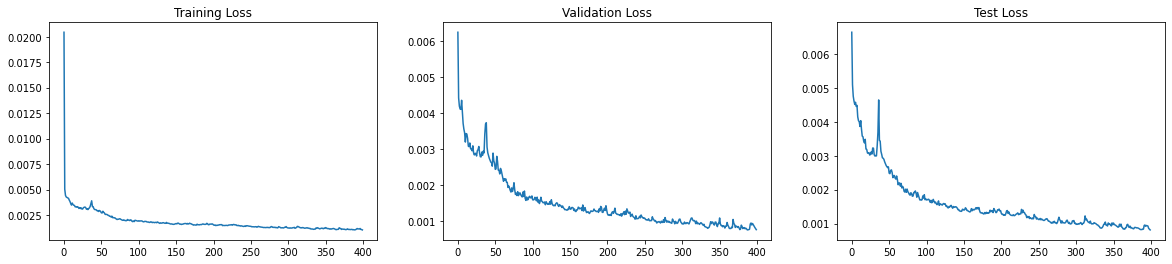

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))

axes[0].plot(range(n_train_epochs), train_loss, label='Train loss')
axes[0].set_title('Training Loss')
axes[1].plot(range(n_train_epochs), val_loss, label='Val loss')
axes[1].set_title('Validation Loss')
axes[2].plot(range(n_train_epochs), test_loss, label='Test loss')
axes[2].set_title('Test Loss')

In [12]:
# Load model with best per-validation loss (uncomment when ready)
best_epoch = load_state_dicts(out_file, model=model)
print('per-validation optimal epoch', best_epoch)

per-validation optimal epoch 380


In [16]:
# Reconstruct from best model
recons, losses = model.reconstruct(loaders['test'], device=device)
recons = torch.cat(recons, dim=0)
losses = torch.cat(losses, dim=0)

In [17]:
recon_losses = losses.cpu().numpy()
mean_loss = np.mean(recon_losses)
print('Reconstruction loss: ', mean_loss)

Reconstruction loss:  0.00097034336


Example:  8a67fd47001e52414c350d7ea5fe2a3a


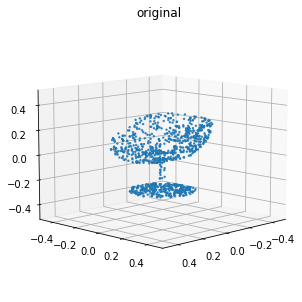

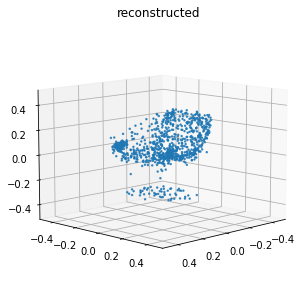

Example:  1e0580f443a9e6d2593ebeeedbff73b


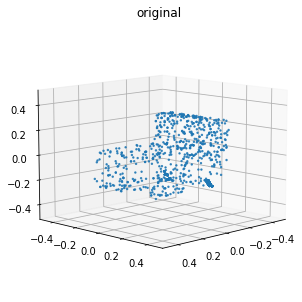

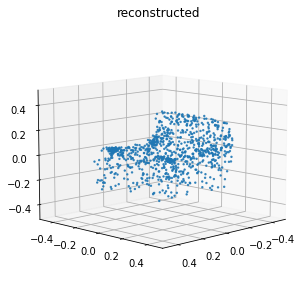

Example:  d3562f992aa405b214b1fd95dbca05


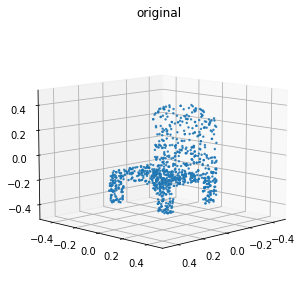

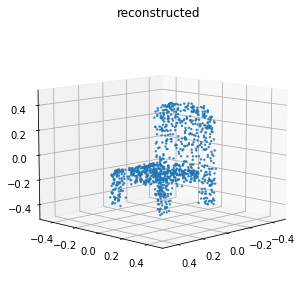

Example:  4e8d8792a3a6390b36b0f2a1430e993a


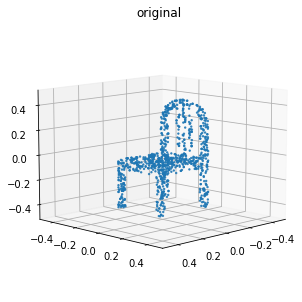

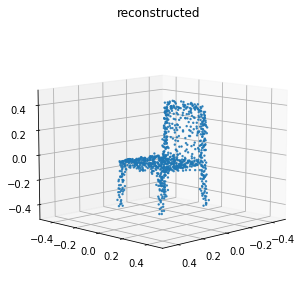

Example:  58479a7b7c157865e68f66efebc71317


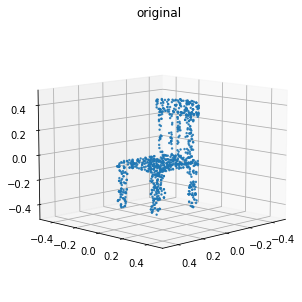

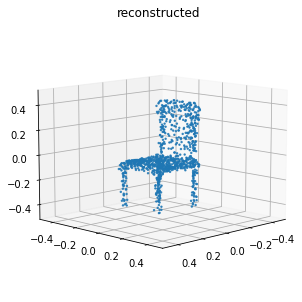

In [18]:
# Students TODO: MAKE your plots and analysis

# 5 examples to visualize per questions (e, f)
examples_to_visualize = ['8a67fd47001e52414c350d7ea5fe2a3a',
                         '1e0580f443a9e6d2593ebeeedbff73b',
                         'd3562f992aa405b214b1fd95dbca05',
                         '4e8d8792a3a6390b36b0f2a1430e993a',
                         '58479a7b7c157865e68f66efebc71317']
# You can (also) use the function for the reconstructions or the part-predictions 
# (for the latter check the kwargs parameter 'c' of matplotlib.
# plot_3d_point_cloud, eg. try plot_3d_point_cloud(loaders['test'].dataset.pointclouds[0])

for example in examples_to_visualize:
    print("Example: ", example)
    index = np.where(loaders['test'].dataset.model_names == example)
    index = np.int(index[0])
    
    
    # Plot side by side
    #f, axarr = plt.subplots(1,2)
    
    orig = plot_3d_point_cloud(loaders['test'].dataset.pointclouds[index], title = 'original')
    recon = plot_3d_point_cloud(recons[index].cpu(), title = 'reconstructed')
    
    #axarr[1].imshow(recon)




#model.eval()   # Do not forget this.! We are not training any more (OK, since we do not 
               # have batch-norm, drop-out etc. this is not so important, however it is good standard 
               # practice)

Best Example:  58479a7b7c157865e68f66efebc71317
Chamfer distance:  0.00031037952


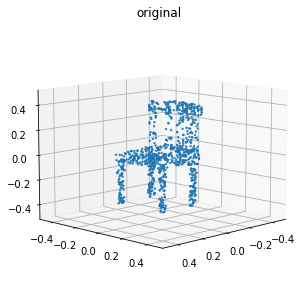

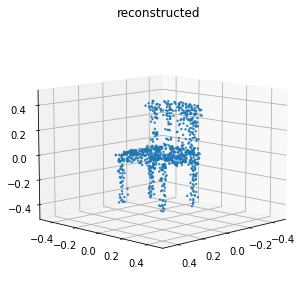

Worst Example:  58479a7b7c157865e68f66efebc71317
Chamfer distance:  0.0020807164


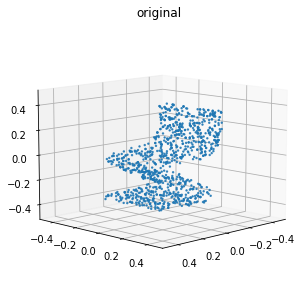

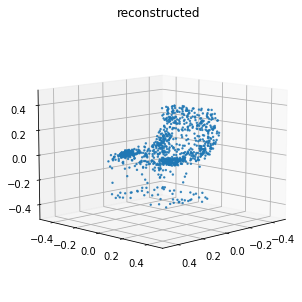

In [19]:
# Best and worst
min_example = recon_losses.argmin()
max_example = recon_losses.argmax()

print("Best Example: ", example)
print("Chamfer distance: ", recon_losses.min())
orig = plot_3d_point_cloud(loaders['test'].dataset.pointclouds[min_example], title = 'original')
recon = plot_3d_point_cloud(recons[min_example].cpu(), title = 'reconstructed')

print("Worst Example: ", example)
print("Chamfer distance: ", recon_losses.max())
orig = plot_3d_point_cloud(loaders['test'].dataset.pointclouds[max_example], title = 'original')
recon = plot_3d_point_cloud(recons[max_example].cpu(), title = 'reconstructed')

Next, extract the latent vectors at the end of the encoder for the pointclouds in the test-split and compute their 2D T-SNE embeddings. How do the T-SNE
neighborhoods look? You can use sklearn’s corresponding function to make the T-SNE plot and utilize the provided rendered images of each model.

In [129]:
model.eval()   # Do not forget this.! We are not training any more (OK, since we do not 
               # have batch-norm, drop-out etc. this is not so important, however it is good standard 
               # practice)

PointcloudAutoencoder(
  (encoder): PointNet(
    (layers): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): ReLU()
      (8): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
    (pool): MaxPool1d(kernel_size=1024, stride=1024, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=384, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=384, out_features=3072, bias=True)
    )
  )
)

In [153]:
# Last, save the latent codes of the test data and go to the 
# measuring_part_awareness and tsne_plot_with_latent_codes code.

# Students TODO: Extract the latent codes and save them, so you can analyze them later.
latent_codes, test_names = model.extract_latent_code(loaders['test'], device=device)   

latent_codes = latent_codes.cpu()

np.savez(osp.join(top_out_dir, model_tag +'_latent_codes'), 
         latent_codes=latent_codes, 
         test_names=test_names)

torch.Size([128, 128])
torch.Size([22, 128])


## 2. Part-aware model

In [7]:
part_aware_model = True # or True

if part_aware_model:
    xentropy = nn.CrossEntropyLoss()
    model = PartAwarePointcloudAutoencoder(encoder, decoder, part_classifier, part_lambda).to(device) # Students Work here
    model_tag = 'part_pc_ae'
else:
    model = PointcloudAutoencoder(encoder, decoder).to(device)  # Students Work here
    model_tag = 'pc_ae'

In [8]:
print(model)

PartAwarePointcloudAutoencoder(
  (encoder): PointNet(
    (layers): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): ReLU()
      (8): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
    (pool): MaxPool1d(kernel_size=1024, stride=1024, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=384, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=384, out_features=3072, bias=True)
    )
  )
  (part_classifier): part_classifier(
    (layers): Sequential(
      (0): Conv1d(131, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 4, ker

In [9]:
optimizer = optim.Adam(model.parameters(), lr=init_lr)  # Students uncomment once you have defined your model

In [10]:
## Train for multiple epochs your model.
# Students: the below for-loops are optional, feel free to structure your training 
# differently.

min_val_loss = np.Inf
out_file = osp.join(top_out_dir, model_tag + 'best_model.pth')
start_epoch = 1

train_xe_loss = []
val_xe_loss = []
test_xe_loss = []


train_chamfer_loss = []
val_chamfer_loss = []
test_chamfer_loss = []

train_joint_loss = []
val_joint_loss = []
test_joint_loss = []


for epoch in tqdm.tqdm(range(start_epoch, start_epoch + n_train_epochs)):
    for phase in ['train', 'val', 'test']:        
        ### Students Work Here.
        joint_loss, chamfer_loss, xe_loss = model.train_for_one_epoch(loaders[phase], optimizer, device)
        print(phase, "joint loss: ", joint_loss, " chamfer loss: ", chamfer_loss, "xe loss: ", xe_loss)
        if phase == 'train':
            train_chamfer_loss.append(chamfer_loss.item())
            train_joint_loss.append(joint_loss.item())
            train_xe_loss.append(xe_loss.item())
        elif phase == 'val':
            val_chamfer_loss.append(chamfer_loss.item())
            val_joint_loss.append(joint_loss.item())
            val_xe_loss.append(xe_loss.item())
        elif phase == 'test':
            test_chamfer_loss.append(chamfer_loss.item())
            test_joint_loss.append(joint_loss.item())
            test_xe_loss.append(xe_loss.item())
            
        if phase == 'val' and joint_loss < min_val_loss: # Save model if validation loss improved.
            min_val_loss = joint_loss
            save_state_dicts(out_file, epoch=epoch, model=model) # If you save the model like this, you can use the code below to load it. 

  0%|          | 1/400 [00:00<04:44,  1.40it/s]

train joint loss:  tensor(0.0326, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0261, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(1.2930, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0123, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(1.1974, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0128, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(1.1777, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 2/400 [00:01<04:13,  1.57it/s]

train joint loss:  tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(1.1548, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(1.0512, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(1.0327, device='cuda:0', grad_fn=<DivBackward0>)


  1%|          | 3/400 [00:01<04:01,  1.64it/s]

train joint loss:  tensor(0.0094, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.9681, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0086, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.8733, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.8582, device='cuda:0', grad_fn=<DivBackward0>)


  1%|          | 4/400 [00:02<03:54,  1.69it/s]

train joint loss:  tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.8090, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.7305, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.7309, device='cuda:0', grad_fn=<DivBackward0>)


  1%|▏         | 5/400 [00:03<03:49,  1.72it/s]

train joint loss:  tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.7094, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.6452, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.6520, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 6/400 [00:03<03:46,  1.74it/s]

train joint loss:  tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.6410, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5886, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.6025, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 7/400 [00:04<03:42,  1.76it/s]

train joint loss:  tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5998, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5501, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5747, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 8/400 [00:04<03:41,  1.77it/s]

train joint loss:  tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5738, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5258, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5550, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▏         | 9/400 [00:05<03:40,  1.77it/s]

train joint loss:  tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5603, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5080, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5536, device='cuda:0', grad_fn=<DivBackward0>)


  2%|▎         | 10/400 [00:05<03:39,  1.77it/s]

train joint loss:  tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5437, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4960, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5450, device='cuda:0', grad_fn=<DivBackward0>)


  3%|▎         | 11/400 [00:06<03:39,  1.77it/s]

train joint loss:  tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5270, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4781, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5333, device='cuda:0', grad_fn=<DivBackward0>)


  3%|▎         | 12/400 [00:06<03:38,  1.77it/s]

train joint loss:  tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5134, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4567, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.5145, device='cuda:0', grad_fn=<DivBackward0>)


  3%|▎         | 13/400 [00:07<03:36,  1.79it/s]

train joint loss:  tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4943, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4401, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4986, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▎         | 14/400 [00:08<03:36,  1.78it/s]

train joint loss:  tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4846, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4292, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4850, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 15/400 [00:08<03:36,  1.78it/s]

train joint loss:  tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4768, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4031, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4915, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 16/400 [00:09<03:35,  1.78it/s]

train joint loss:  tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4683, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3966, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4656, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 17/400 [00:09<03:35,  1.78it/s]

train joint loss:  tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4590, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3944, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4669, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 18/400 [00:10<03:33,  1.79it/s]

train joint loss:  tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4617, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3992, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4904, device='cuda:0', grad_fn=<DivBackward0>)


  5%|▍         | 19/400 [00:10<03:31,  1.80it/s]

train joint loss:  tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4621, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3782, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4630, device='cuda:0', grad_fn=<DivBackward0>)


  5%|▌         | 20/400 [00:11<03:31,  1.80it/s]

train joint loss:  tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4648, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3887, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4492, device='cuda:0', grad_fn=<DivBackward0>)


  5%|▌         | 21/400 [00:11<03:31,  1.79it/s]

train joint loss:  tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4556, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3832, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4544, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 22/400 [00:12<03:31,  1.79it/s]

train joint loss:  tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4446, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3840, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4465, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 23/400 [00:13<03:31,  1.78it/s]

train joint loss:  tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4521, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3750, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4491, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 24/400 [00:13<03:29,  1.79it/s]

train joint loss:  tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4485, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3683, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4479, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▋         | 25/400 [00:14<03:28,  1.80it/s]

train joint loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4450, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3735, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4384, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▋         | 26/400 [00:14<03:29,  1.79it/s]

train joint loss:  tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4616, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3714, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4435, device='cuda:0', grad_fn=<DivBackward0>)


  7%|▋         | 27/400 [00:15<03:27,  1.80it/s]

train joint loss:  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4437, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3832, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4367, device='cuda:0', grad_fn=<DivBackward0>)


  7%|▋         | 28/400 [00:15<03:28,  1.78it/s]

train joint loss:  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4361, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3628, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4380, device='cuda:0', grad_fn=<DivBackward0>)


  7%|▋         | 29/400 [00:16<03:26,  1.79it/s]

train joint loss:  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4426, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3716, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4375, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 30/400 [00:16<03:25,  1.80it/s]

train joint loss:  tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4376, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3638, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4302, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 31/400 [00:17<03:26,  1.79it/s]

train joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4420, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3690, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4300, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 32/400 [00:18<03:26,  1.78it/s]

train joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4296, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3599, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4289, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 33/400 [00:18<03:25,  1.78it/s]

train joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4280, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3733, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4243, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 34/400 [00:19<03:24,  1.79it/s]

train joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4289, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3905, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4332, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▉         | 35/400 [00:19<03:22,  1.80it/s]

train joint loss:  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4325, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3634, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4237, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▉         | 36/400 [00:20<03:23,  1.78it/s]

train joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4327, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3579, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4201, device='cuda:0', grad_fn=<DivBackward0>)


  9%|▉         | 37/400 [00:20<03:22,  1.80it/s]

train joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4240, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3549, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4173, device='cuda:0', grad_fn=<DivBackward0>)


 10%|▉         | 38/400 [00:21<03:21,  1.80it/s]

train joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4214, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3645, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4236, device='cuda:0', grad_fn=<DivBackward0>)


 10%|▉         | 39/400 [00:21<03:19,  1.81it/s]

train joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4284, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3613, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4102, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 40/400 [00:22<03:21,  1.78it/s]

train joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4196, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3535, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4267, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 41/400 [00:23<03:20,  1.79it/s]

train joint loss:  tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4115, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3646, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4175, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 42/400 [00:23<03:18,  1.80it/s]

train joint loss:  tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4078, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3579, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3964, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█         | 43/400 [00:24<03:17,  1.81it/s]

train joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3952, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3638, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3966, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█         | 44/400 [00:24<03:16,  1.81it/s]

train joint loss:  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.4163, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3530, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3958, device='cuda:0', grad_fn=<DivBackward0>)


 11%|█▏        | 45/400 [00:25<03:18,  1.79it/s]

train joint loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3861, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3504, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3883, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 46/400 [00:25<03:18,  1.78it/s]

train joint loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3831, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3395, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3876, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 47/400 [00:26<03:16,  1.79it/s]

train joint loss:  tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3876, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3549, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3874, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 48/400 [00:27<03:18,  1.78it/s]

train joint loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3815, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3413, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3797, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 49/400 [00:27<03:18,  1.77it/s]

train joint loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3727, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3431, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3803, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▎        | 50/400 [00:28<03:16,  1.78it/s]

train joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3801, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3489, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3836, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 51/400 [00:28<03:17,  1.77it/s]

train joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3754, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3455, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3806, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 52/400 [00:29<03:15,  1.78it/s]

train joint loss:  tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3845, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3409, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3872, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 53/400 [00:29<03:13,  1.79it/s]

train joint loss:  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3815, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3399, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3775, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▎        | 54/400 [00:30<03:12,  1.79it/s]

train joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3713, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3404, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3788, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 55/400 [00:30<03:13,  1.78it/s]

train joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3769, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3328, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3754, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 56/400 [00:31<03:14,  1.77it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3676, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3376, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3687, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 57/400 [00:32<03:11,  1.79it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3680, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3413, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3833, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 58/400 [00:32<03:12,  1.78it/s]

train joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3772, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3376, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3723, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▍        | 59/400 [00:33<03:12,  1.77it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3662, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3336, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3742, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 60/400 [00:33<03:12,  1.76it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3671, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3350, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3711, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 61/400 [00:34<03:10,  1.78it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3684, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3479, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3703, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 62/400 [00:34<03:08,  1.79it/s]

train joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3654, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3489, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3815, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 63/400 [00:35<03:07,  1.80it/s]

train joint loss:  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3878, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3383, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3834, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 64/400 [00:36<03:08,  1.78it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3714, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3267, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3673, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▋        | 65/400 [00:36<03:07,  1.79it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3704, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3329, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3668, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▋        | 66/400 [00:37<03:05,  1.80it/s]

train joint loss:  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3688, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3287, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3660, device='cuda:0', grad_fn=<DivBackward0>)


 17%|█▋        | 67/400 [00:37<03:04,  1.80it/s]

train joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3612, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3337, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3616, device='cuda:0', grad_fn=<DivBackward0>)


 17%|█▋        | 68/400 [00:38<03:03,  1.81it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3613, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3429, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3748, device='cuda:0', grad_fn=<DivBackward0>)


 17%|█▋        | 69/400 [00:38<03:02,  1.81it/s]

train joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3781, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3262, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3670, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 70/400 [00:39<03:01,  1.82it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3645, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3351, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3595, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 71/400 [00:39<03:03,  1.80it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3627, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3281, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3692, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 72/400 [00:40<03:02,  1.80it/s]

train joint loss:  tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3669, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3415, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3727, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 73/400 [00:41<03:03,  1.78it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3605, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3259, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3600, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 74/400 [00:41<03:02,  1.79it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3597, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3320, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3606, device='cuda:0', grad_fn=<DivBackward0>)


 19%|█▉        | 75/400 [00:42<03:03,  1.77it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3678, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3294, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3638, device='cuda:0', grad_fn=<DivBackward0>)


 19%|█▉        | 76/400 [00:42<03:01,  1.79it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3253, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3559, device='cuda:0', grad_fn=<DivBackward0>)


 19%|█▉        | 77/400 [00:43<02:59,  1.80it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3591, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3281, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3575, device='cuda:0', grad_fn=<DivBackward0>)


 20%|█▉        | 78/400 [00:43<03:01,  1.77it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3527, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3271, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3532, device='cuda:0', grad_fn=<DivBackward0>)


 20%|█▉        | 79/400 [00:44<02:59,  1.78it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3564, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3239, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3504, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 80/400 [00:44<03:00,  1.77it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3534, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3235, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3553, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 81/400 [00:45<02:58,  1.78it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3532, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3205, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3441, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 82/400 [00:46<02:57,  1.79it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3485, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3204, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3581, device='cuda:0', grad_fn=<DivBackward0>)


 21%|██        | 83/400 [00:46<02:58,  1.78it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3583, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3237, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3510, device='cuda:0', grad_fn=<DivBackward0>)


 21%|██        | 84/400 [00:47<02:59,  1.76it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3491, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3207, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3481, device='cuda:0', grad_fn=<DivBackward0>)


 21%|██▏       | 85/400 [00:47<02:57,  1.78it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3538, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3255, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3477, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 86/400 [00:48<02:55,  1.79it/s]

train joint loss:  tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3552, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3390, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3479, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 87/400 [00:48<02:54,  1.80it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3484, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3235, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3421, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 88/400 [00:49<02:53,  1.80it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3425, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3169, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3391, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 89/400 [00:49<02:52,  1.80it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3466, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3236, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3353, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▎       | 90/400 [00:50<02:51,  1.80it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3448, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3129, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3335, device='cuda:0', grad_fn=<DivBackward0>)


 23%|██▎       | 91/400 [00:51<02:51,  1.80it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3420, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3264, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3298, device='cuda:0', grad_fn=<DivBackward0>)


 23%|██▎       | 92/400 [00:51<02:50,  1.80it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3387, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3255, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3317, device='cuda:0', grad_fn=<DivBackward0>)


 23%|██▎       | 93/400 [00:52<02:49,  1.81it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3433, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3122, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3285, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▎       | 94/400 [00:52<02:49,  1.81it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3406, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3630, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3358, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 95/400 [00:53<02:48,  1.81it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3488, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3333, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3481, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 96/400 [00:53<02:49,  1.79it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3429, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3215, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3449, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 97/400 [00:54<02:48,  1.80it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3643, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3233, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3533, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 98/400 [00:54<02:49,  1.78it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3458, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3150, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3368, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▍       | 99/400 [00:55<02:50,  1.77it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3401, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3197, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3317, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 100/400 [00:56<02:50,  1.76it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3374, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3148, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3372, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 101/400 [00:56<02:48,  1.78it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3384, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3213, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3291, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 102/400 [00:57<02:48,  1.76it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3379, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3091, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3330, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 103/400 [00:57<02:47,  1.78it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3477, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3557, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3458, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 104/400 [00:58<02:45,  1.79it/s]

train joint loss:  tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3561, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3178, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3345, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▋       | 105/400 [00:58<02:44,  1.79it/s]

train joint loss:  tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3404, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3110, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3277, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▋       | 106/400 [00:59<02:45,  1.77it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3379, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3175, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3311, device='cuda:0', grad_fn=<DivBackward0>)


 27%|██▋       | 107/400 [01:00<02:46,  1.76it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3348, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3209, device='cuda:0', grad_fn=<DivBackward0>)


 27%|██▋       | 108/400 [01:00<02:44,  1.78it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3365, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3093, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3209, device='cuda:0', grad_fn=<DivBackward0>)


 27%|██▋       | 109/400 [01:01<02:42,  1.79it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3321, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3102, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3201, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 110/400 [01:01<02:41,  1.80it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3318, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3150, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3197, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 111/400 [01:02<02:42,  1.78it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3357, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3104, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3207, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 112/400 [01:02<02:41,  1.79it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3342, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3115, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3285, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 113/400 [01:03<02:39,  1.80it/s]

train joint loss:  tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3395, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3209, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3250, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 114/400 [01:03<02:40,  1.78it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3308, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3093, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3230, device='cuda:0', grad_fn=<DivBackward0>)


 29%|██▉       | 115/400 [01:04<02:41,  1.77it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3317, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3060, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3174, device='cuda:0', grad_fn=<DivBackward0>)


 29%|██▉       | 116/400 [01:05<02:39,  1.78it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3268, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3061, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3126, device='cuda:0', grad_fn=<DivBackward0>)


 29%|██▉       | 117/400 [01:05<02:37,  1.79it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3257, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3132, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3154, device='cuda:0', grad_fn=<DivBackward0>)


 30%|██▉       | 118/400 [01:06<02:36,  1.80it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3412, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3110, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3128, device='cuda:0', grad_fn=<DivBackward0>)


 30%|██▉       | 119/400 [01:06<02:35,  1.80it/s]

train joint loss:  tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3300, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3076, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3196, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 120/400 [01:07<02:35,  1.80it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3266, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3161, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3176, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 121/400 [01:07<02:34,  1.80it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3298, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3083, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3137, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 122/400 [01:08<02:35,  1.79it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3246, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3054, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3128, device='cuda:0', grad_fn=<DivBackward0>)


 31%|███       | 123/400 [01:08<02:34,  1.80it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3282, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3090, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3247, device='cuda:0', grad_fn=<DivBackward0>)


 31%|███       | 124/400 [01:09<02:35,  1.78it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3278, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3038, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3153, device='cuda:0', grad_fn=<DivBackward0>)


 31%|███▏      | 125/400 [01:10<02:33,  1.79it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3266, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3073, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3127, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 126/400 [01:10<02:32,  1.80it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3263, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3044, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3102, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 127/400 [01:11<02:33,  1.78it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3292, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3030, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3149, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 128/400 [01:11<02:32,  1.79it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3277, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3153, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3163, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 129/400 [01:12<02:31,  1.79it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3260, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3156, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3160, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▎      | 130/400 [01:12<02:32,  1.78it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3269, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3076, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3123, device='cuda:0', grad_fn=<DivBackward0>)


 33%|███▎      | 131/400 [01:13<02:32,  1.77it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3216, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3034, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3054, device='cuda:0', grad_fn=<DivBackward0>)


 33%|███▎      | 132/400 [01:14<02:30,  1.78it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3240, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3044, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3144, device='cuda:0', grad_fn=<DivBackward0>)


 33%|███▎      | 133/400 [01:14<02:29,  1.79it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3231, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3019, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▎      | 134/400 [01:15<02:27,  1.80it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3261, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3085, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 135/400 [01:15<02:27,  1.80it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3235, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3051, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3059, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 136/400 [01:16<02:27,  1.79it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3222, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3057, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3137, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 137/400 [01:16<02:26,  1.80it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3228, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3061, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3156, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 138/400 [01:17<02:25,  1.80it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3242, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3046, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3110, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▍      | 139/400 [01:17<02:24,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3301, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3052, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3052, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 140/400 [01:18<02:23,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3222, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3248, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3166, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 141/400 [01:19<02:23,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3235, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3043, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3127, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▌      | 142/400 [01:19<02:22,  1.81it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3238, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3074, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3147, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▌      | 143/400 [01:20<02:22,  1.81it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3332, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3137, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3113, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▌      | 144/400 [01:20<02:23,  1.79it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3248, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3059, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3057, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▋      | 145/400 [01:21<02:23,  1.77it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3264, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2996, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3314, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▋      | 146/400 [01:21<02:22,  1.79it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3290, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3039, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)


 37%|███▋      | 147/400 [01:22<02:21,  1.79it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3238, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3100, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3080, device='cuda:0', grad_fn=<DivBackward0>)


 37%|███▋      | 148/400 [01:22<02:20,  1.80it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3251, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3150, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3118, device='cuda:0', grad_fn=<DivBackward0>)


 37%|███▋      | 149/400 [01:23<02:19,  1.80it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3401, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3295, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3145, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 150/400 [01:24<02:18,  1.80it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3317, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3176, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 151/400 [01:24<02:17,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3254, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3032, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3170, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 152/400 [01:25<02:16,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3225, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3217, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3119, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 153/400 [01:25<02:16,  1.81it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3255, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3207, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3137, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 154/400 [01:26<02:15,  1.81it/s]

train joint loss:  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3241, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3096, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3103, device='cuda:0', grad_fn=<DivBackward0>)


 39%|███▉      | 155/400 [01:26<02:15,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3215, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3000, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3114, device='cuda:0', grad_fn=<DivBackward0>)


 39%|███▉      | 156/400 [01:27<02:14,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3220, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3136, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3063, device='cuda:0', grad_fn=<DivBackward0>)


 39%|███▉      | 157/400 [01:27<02:13,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3220, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3041, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)


 40%|███▉      | 158/400 [01:28<02:13,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3210, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2998, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)


 40%|███▉      | 159/400 [01:28<02:13,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3276, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3037, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3084, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 160/400 [01:29<02:12,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3175, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3019, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3011, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 161/400 [01:30<02:13,  1.79it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3182, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3000, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3031, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 162/400 [01:30<02:12,  1.79it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3228, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2989, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3015, device='cuda:0', grad_fn=<DivBackward0>)


 41%|████      | 163/400 [01:31<02:13,  1.77it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3160, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3003, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2982, device='cuda:0', grad_fn=<DivBackward0>)


 41%|████      | 164/400 [01:31<02:13,  1.76it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3149, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2989, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3009, device='cuda:0', grad_fn=<DivBackward0>)


 41%|████▏     | 165/400 [01:32<02:13,  1.76it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3202, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2977, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3053, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 166/400 [01:32<02:12,  1.76it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3170, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2925, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3031, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 167/400 [01:33<02:11,  1.78it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3177, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3165, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3008, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 168/400 [01:34<02:09,  1.79it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3237, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3222, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3124, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 169/400 [01:34<02:08,  1.80it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3256, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3089, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3105, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▎     | 170/400 [01:35<02:07,  1.80it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3202, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3023, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3069, device='cuda:0', grad_fn=<DivBackward0>)


 43%|████▎     | 171/400 [01:35<02:06,  1.80it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3261, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2979, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3070, device='cuda:0', grad_fn=<DivBackward0>)


 43%|████▎     | 172/400 [01:36<02:06,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3244, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2984, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3030, device='cuda:0', grad_fn=<DivBackward0>)


 43%|████▎     | 173/400 [01:36<02:05,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3166, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3029, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3030, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▎     | 174/400 [01:37<02:04,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3164, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2987, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3026, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 175/400 [01:37<02:04,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3188, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2964, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3052, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 176/400 [01:38<02:03,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3170, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2951, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2997, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 177/400 [01:39<02:03,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3167, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3019, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2982, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 178/400 [01:39<02:02,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3188, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2971, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3005, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▍     | 179/400 [01:40<02:02,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3149, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3044, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2998, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 180/400 [01:40<02:01,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3252, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3035, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3183, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 181/400 [01:41<02:01,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3247, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3068, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3039, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▌     | 182/400 [01:41<02:00,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3229, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2965, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3050, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▌     | 183/400 [01:42<01:59,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3167, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2969, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3004, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▌     | 184/400 [01:42<01:59,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3167, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3032, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3016, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▋     | 185/400 [01:43<01:58,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3168, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2972, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2956, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▋     | 186/400 [01:44<01:59,  1.79it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3121, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2931, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2984, device='cuda:0', grad_fn=<DivBackward0>)


 47%|████▋     | 187/400 [01:44<01:58,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3132, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2952, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3043, device='cuda:0', grad_fn=<DivBackward0>)


 47%|████▋     | 188/400 [01:45<01:59,  1.78it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3173, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2946, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3004, device='cuda:0', grad_fn=<DivBackward0>)


 47%|████▋     | 189/400 [01:45<01:57,  1.79it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3162, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2960, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2989, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 190/400 [01:46<01:56,  1.79it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3238, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2951, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3041, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 191/400 [01:46<01:55,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3139, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2937, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3019, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 192/400 [01:47<01:55,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3185, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2933, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3025, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 193/400 [01:47<01:54,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3173, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2985, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3106, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 194/400 [01:48<01:53,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3243, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3140, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3014, device='cuda:0', grad_fn=<DivBackward0>)


 49%|████▉     | 195/400 [01:49<01:53,  1.81it/s]

train joint loss:  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3333, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3003, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3086, device='cuda:0', grad_fn=<DivBackward0>)


 49%|████▉     | 196/400 [01:49<01:52,  1.81it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3183, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2970, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3066, device='cuda:0', grad_fn=<DivBackward0>)


 49%|████▉     | 197/400 [01:50<01:52,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3147, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3026, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2997, device='cuda:0', grad_fn=<DivBackward0>)


 50%|████▉     | 198/400 [01:50<01:51,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3159, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2960, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2994, device='cuda:0', grad_fn=<DivBackward0>)


 50%|████▉     | 199/400 [01:51<01:51,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3132, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3009, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2960, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 200/400 [01:51<01:50,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3125, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3061, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3045, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 201/400 [01:52<01:50,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3139, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2934, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2997, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 202/400 [01:52<01:49,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3160, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2983, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2997, device='cuda:0', grad_fn=<DivBackward0>)


 51%|█████     | 203/400 [01:53<01:48,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3125, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2949, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2998, device='cuda:0', grad_fn=<DivBackward0>)


 51%|█████     | 204/400 [01:54<01:49,  1.79it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3187, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2915, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2969, device='cuda:0', grad_fn=<DivBackward0>)


 51%|█████▏    | 205/400 [01:54<01:48,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3120, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2962, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2964, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 206/400 [01:55<01:47,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3144, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2952, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2938, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 207/400 [01:55<01:46,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3125, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2921, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2989, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 208/400 [01:56<01:46,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3161, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2938, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3033, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 209/400 [01:56<01:45,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3149, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2964, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2988, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▎    | 210/400 [01:57<01:46,  1.79it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2908, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3010, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 211/400 [01:57<01:45,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3117, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2944, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2958, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 212/400 [01:58<01:44,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3197, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3208, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3114, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 213/400 [01:58<01:43,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3291, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2977, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▎    | 214/400 [01:59<01:42,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3209, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2974, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3028, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 215/400 [02:00<01:42,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3160, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2978, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2943, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 216/400 [02:00<01:41,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3118, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2925, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2963, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 217/400 [02:01<01:41,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3130, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2972, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2977, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▍    | 218/400 [02:01<01:40,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3145, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2910, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2972, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▍    | 219/400 [02:02<01:41,  1.79it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3098, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2898, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2958, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 220/400 [02:02<01:40,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3083, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2966, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2964, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 221/400 [02:03<01:39,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3199, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2968, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3049, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 222/400 [02:03<01:38,  1.80it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3269, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2928, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3079, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 223/400 [02:04<01:38,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3135, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3022, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 224/400 [02:05<01:37,  1.80it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3140, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2925, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2955, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▋    | 225/400 [02:05<01:37,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3098, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2923, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2973, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▋    | 226/400 [02:06<01:36,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3168, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2961, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3006, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 227/400 [02:06<01:35,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3176, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2968, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3002, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 228/400 [02:07<01:35,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3127, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2903, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2950, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 229/400 [02:07<01:34,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3102, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2897, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2946, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▊    | 230/400 [02:08<01:35,  1.79it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3070, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2886, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2912, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 231/400 [02:08<01:34,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3073, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2899, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2935, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 232/400 [02:09<01:33,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3091, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2905, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2925, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 233/400 [02:10<01:32,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3121, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2944, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2977, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 234/400 [02:10<01:31,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3104, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2911, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2969, device='cuda:0', grad_fn=<DivBackward0>)


 59%|█████▉    | 235/400 [02:11<01:31,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3121, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2976, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2957, device='cuda:0', grad_fn=<DivBackward0>)


 59%|█████▉    | 236/400 [02:11<01:30,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3142, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2921, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3006, device='cuda:0', grad_fn=<DivBackward0>)


 59%|█████▉    | 237/400 [02:12<01:29,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3092, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2927, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2913, device='cuda:0', grad_fn=<DivBackward0>)


 60%|█████▉    | 238/400 [02:12<01:29,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3110, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2870, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2932, device='cuda:0', grad_fn=<DivBackward0>)


 60%|█████▉    | 239/400 [02:13<01:28,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3161, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2878, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3049, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 240/400 [02:13<01:28,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3144, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2957, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 241/400 [02:14<01:27,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3074, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2988, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2984, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 242/400 [02:15<01:27,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3240, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2886, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3051, device='cuda:0', grad_fn=<DivBackward0>)


 61%|██████    | 243/400 [02:15<01:26,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3162, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2954, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2995, device='cuda:0', grad_fn=<DivBackward0>)


 61%|██████    | 244/400 [02:16<01:25,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3092, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2965, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2979, device='cuda:0', grad_fn=<DivBackward0>)


 61%|██████▏   | 245/400 [02:16<01:25,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3141, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2962, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3067, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 246/400 [02:17<01:24,  1.82it/s]

train joint loss:  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3311, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2986, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 247/400 [02:17<01:24,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3129, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2932, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2995, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 248/400 [02:18<01:23,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3103, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3018, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2945, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 249/400 [02:18<01:23,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3093, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2918, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2942, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▎   | 250/400 [02:19<01:23,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3153, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3050, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2997, device='cuda:0', grad_fn=<DivBackward0>)


 63%|██████▎   | 251/400 [02:20<01:22,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3138, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2935, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3045, device='cuda:0', grad_fn=<DivBackward0>)


 63%|██████▎   | 252/400 [02:20<01:21,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3197, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3007, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2995, device='cuda:0', grad_fn=<DivBackward0>)


 63%|██████▎   | 253/400 [02:21<01:21,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3143, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3004, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2960, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▎   | 254/400 [02:21<01:20,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3110, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3074, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2974, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 255/400 [02:22<01:19,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3094, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2928, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2930, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 256/400 [02:22<01:19,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3095, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2947, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2949, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 257/400 [02:23<01:19,  1.79it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3091, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2870, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2911, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 258/400 [02:23<01:18,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3108, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2898, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2946, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▍   | 259/400 [02:24<01:18,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3076, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2917, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2922, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 260/400 [02:24<01:17,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2892, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2917, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 261/400 [02:25<01:16,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3077, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2914, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2976, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▌   | 262/400 [02:26<01:16,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3100, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2960, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2903, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▌   | 263/400 [02:26<01:16,  1.79it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3116, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2902, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2987, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▌   | 264/400 [02:27<01:16,  1.77it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3085, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2878, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▋   | 265/400 [02:27<01:15,  1.78it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3149, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2915, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2953, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▋   | 266/400 [02:28<01:14,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2964, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2957, device='cuda:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 267/400 [02:28<01:14,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3076, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2890, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2960, device='cuda:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 268/400 [02:29<01:13,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3065, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2862, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2922, device='cuda:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 269/400 [02:30<01:12,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3076, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2940, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 270/400 [02:30<01:11,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3082, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2892, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2967, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 271/400 [02:31<01:11,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3100, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2936, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3103, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 272/400 [02:31<01:10,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3113, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2945, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3066, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 273/400 [02:32<01:10,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3152, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3018, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2990, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 274/400 [02:32<01:09,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3097, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2943, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2988, device='cuda:0', grad_fn=<DivBackward0>)


 69%|██████▉   | 275/400 [02:33<01:08,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3092, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2915, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3013, device='cuda:0', grad_fn=<DivBackward0>)


 69%|██████▉   | 276/400 [02:33<01:08,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3190, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2925, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3018, device='cuda:0', grad_fn=<DivBackward0>)


 69%|██████▉   | 277/400 [02:34<01:07,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2888, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2935, device='cuda:0', grad_fn=<DivBackward0>)


 70%|██████▉   | 278/400 [02:34<01:07,  1.82it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3051, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2903, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2953, device='cuda:0', grad_fn=<DivBackward0>)


 70%|██████▉   | 279/400 [02:35<01:06,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3160, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3045, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2999, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 280/400 [02:36<01:06,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3182, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3010, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3035, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 281/400 [02:36<01:05,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3117, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2931, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2970, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 282/400 [02:37<01:05,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3095, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2949, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2978, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████   | 283/400 [02:37<01:04,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3110, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2894, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2967, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████   | 284/400 [02:38<01:03,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3081, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2994, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2966, device='cuda:0', grad_fn=<DivBackward0>)


 71%|███████▏  | 285/400 [02:38<01:03,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3094, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2923, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2962, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 286/400 [02:39<01:02,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3119, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2919, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2911, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 287/400 [02:39<01:02,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3189, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2880, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3108, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 288/400 [02:40<01:01,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3075, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2913, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2979, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 289/400 [02:41<01:01,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3055, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2888, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2965, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▎  | 290/400 [02:41<01:00,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3070, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2917, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2927, device='cuda:0', grad_fn=<DivBackward0>)


 73%|███████▎  | 291/400 [02:42<01:00,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2864, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)


 73%|███████▎  | 292/400 [02:42<00:59,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3081, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2869, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2971, device='cuda:0', grad_fn=<DivBackward0>)


 73%|███████▎  | 293/400 [02:43<00:59,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3045, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2988, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2969, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▎  | 294/400 [02:43<00:58,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3151, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3106, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3006, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 295/400 [02:44<00:57,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3088, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2932, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2967, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 296/400 [02:44<00:57,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3203, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2963, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3080, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 297/400 [02:45<00:56,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3095, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2939, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2941, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 298/400 [02:46<00:57,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3058, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2865, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2919, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▍  | 299/400 [02:46<00:56,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3058, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2927, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2929, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 300/400 [02:47<00:56,  1.78it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3053, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2865, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2895, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 301/400 [02:47<00:55,  1.77it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3057, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2854, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2934, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▌  | 302/400 [02:48<00:55,  1.78it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3112, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3016, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2959, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▌  | 303/400 [02:48<00:54,  1.79it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3163, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2856, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3036, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▌  | 304/400 [02:49<00:53,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3120, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3063, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2958, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▋  | 305/400 [02:49<00:52,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3080, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2887, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2935, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▋  | 306/400 [02:50<00:52,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3058, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2934, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3000, device='cuda:0', grad_fn=<DivBackward0>)


 77%|███████▋  | 307/400 [02:51<00:51,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3092, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2928, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2958, device='cuda:0', grad_fn=<DivBackward0>)


 77%|███████▋  | 308/400 [02:51<00:51,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3185, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2958, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3005, device='cuda:0', grad_fn=<DivBackward0>)


 77%|███████▋  | 309/400 [02:52<00:50,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3101, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2908, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 310/400 [02:52<00:49,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3046, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2942, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2929, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 311/400 [02:53<00:49,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3044, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2910, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2927, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 312/400 [02:53<00:48,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3042, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2848, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2891, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 313/400 [02:54<00:48,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3043, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2865, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2916, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 314/400 [02:54<00:47,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3045, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2880, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2890, device='cuda:0', grad_fn=<DivBackward0>)


 79%|███████▉  | 315/400 [02:55<00:46,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3012, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2859, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2913, device='cuda:0', grad_fn=<DivBackward0>)


 79%|███████▉  | 316/400 [02:56<00:46,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3081, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2903, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3003, device='cuda:0', grad_fn=<DivBackward0>)


 79%|███████▉  | 317/400 [02:56<00:45,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3056, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2913, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2904, device='cuda:0', grad_fn=<DivBackward0>)


 80%|███████▉  | 318/400 [02:57<00:45,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3049, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2896, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2925, device='cuda:0', grad_fn=<DivBackward0>)


 80%|███████▉  | 319/400 [02:57<00:45,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3063, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2940, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2996, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 320/400 [02:58<00:44,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3088, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2901, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2950, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 321/400 [02:58<00:43,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3071, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2879, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2904, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 322/400 [02:59<00:43,  1.78it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3017, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2833, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2908, device='cuda:0', grad_fn=<DivBackward0>)


 81%|████████  | 323/400 [02:59<00:43,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3045, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2876, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2902, device='cuda:0', grad_fn=<DivBackward0>)


 81%|████████  | 324/400 [03:00<00:42,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3062, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2933, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2945, device='cuda:0', grad_fn=<DivBackward0>)


 81%|████████▏ | 325/400 [03:01<00:41,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3141, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2891, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2983, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 326/400 [03:01<00:41,  1.80it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3077, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2905, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2957, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 327/400 [03:02<00:40,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3066, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2971, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3003, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 328/400 [03:02<00:39,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3114, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2879, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2988, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 329/400 [03:03<00:39,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3167, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2893, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3024, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▎ | 330/400 [03:03<00:38,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2913, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2976, device='cuda:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 331/400 [03:04<00:38,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3150, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2929, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2996, device='cuda:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 332/400 [03:04<00:37,  1.81it/s]

train joint loss:  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3216, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2906, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 333/400 [03:05<00:36,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3099, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2889, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2959, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▎ | 334/400 [03:06<00:36,  1.82it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2937, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2962, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 335/400 [03:06<00:35,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3044, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2968, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2941, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 336/400 [03:07<00:35,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3065, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2893, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2889, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 337/400 [03:07<00:34,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3053, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2881, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2899, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 338/400 [03:08<00:34,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3067, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2907, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2906, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▍ | 339/400 [03:08<00:33,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3004, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2852, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2893, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 340/400 [03:09<00:33,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3038, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2843, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2900, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 341/400 [03:09<00:32,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3041, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2863, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2916, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▌ | 342/400 [03:10<00:32,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3043, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2866, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2934, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▌ | 343/400 [03:10<00:31,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3036, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2862, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2914, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▌ | 344/400 [03:11<00:30,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3133, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2906, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2919, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▋ | 345/400 [03:12<00:30,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3074, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2918, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2939, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▋ | 346/400 [03:12<00:29,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3096, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2994, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2971, device='cuda:0', grad_fn=<DivBackward0>)


 87%|████████▋ | 347/400 [03:13<00:29,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3057, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2869, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2937, device='cuda:0', grad_fn=<DivBackward0>)


 87%|████████▋ | 348/400 [03:13<00:28,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3030, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2864, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2901, device='cuda:0', grad_fn=<DivBackward0>)


 87%|████████▋ | 349/400 [03:14<00:28,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3008, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2865, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2915, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 350/400 [03:14<00:27,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3030, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2923, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3045, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 351/400 [03:15<00:27,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3046, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2859, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2990, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 352/400 [03:15<00:26,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3144, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2899, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2980, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 353/400 [03:16<00:25,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2902, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2904, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 354/400 [03:17<00:25,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3049, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2879, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2902, device='cuda:0', grad_fn=<DivBackward0>)


 89%|████████▉ | 355/400 [03:17<00:24,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3108, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2848, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3016, device='cuda:0', grad_fn=<DivBackward0>)


 89%|████████▉ | 356/400 [03:18<00:24,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3093, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2847, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2918, device='cuda:0', grad_fn=<DivBackward0>)


 89%|████████▉ | 357/400 [03:18<00:23,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3007, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2840, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2890, device='cuda:0', grad_fn=<DivBackward0>)


 90%|████████▉ | 358/400 [03:19<00:23,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3010, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2933, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2899, device='cuda:0', grad_fn=<DivBackward0>)


 90%|████████▉ | 359/400 [03:19<00:22,  1.79it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3055, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2854, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2865, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 360/400 [03:20<00:22,  1.80it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3000, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2843, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2877, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 361/400 [03:20<00:21,  1.78it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3015, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2827, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2905, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 362/400 [03:21<00:21,  1.79it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3003, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2843, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2927, device='cuda:0', grad_fn=<DivBackward0>)


 91%|█████████ | 363/400 [03:22<00:20,  1.79it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3072, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2873, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2990, device='cuda:0', grad_fn=<DivBackward0>)


 91%|█████████ | 364/400 [03:22<00:19,  1.80it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3190, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2898, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2945, device='cuda:0', grad_fn=<DivBackward0>)


 91%|█████████▏| 365/400 [03:23<00:19,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3042, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2953, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2937, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 366/400 [03:23<00:18,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3027, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2875, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2924, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 367/400 [03:24<00:18,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3016, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2851, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2897, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 368/400 [03:24<00:17,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3092, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2896, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2942, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 369/400 [03:25<00:17,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3082, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3066, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2972, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▎| 370/400 [03:25<00:16,  1.82it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3118, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3032, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3002, device='cuda:0', grad_fn=<DivBackward0>)


 93%|█████████▎| 371/400 [03:26<00:15,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3091, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2900, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2895, device='cuda:0', grad_fn=<DivBackward0>)


 93%|█████████▎| 372/400 [03:27<00:15,  1.82it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3034, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2849, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2913, device='cuda:0', grad_fn=<DivBackward0>)


 93%|█████████▎| 373/400 [03:27<00:14,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3047, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2843, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2899, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▎| 374/400 [03:28<00:14,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3078, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2865, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2891, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 375/400 [03:28<00:13,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3009, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2828, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2901, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 376/400 [03:29<00:13,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3012, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2833, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2897, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 377/400 [03:29<00:12,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3051, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2840, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2936, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 378/400 [03:30<00:12,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3014, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2891, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2933, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▍| 379/400 [03:30<00:11,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3050, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2885, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2909, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 380/400 [03:31<00:11,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2906, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3002, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 381/400 [03:31<00:10,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3079, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2863, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2945, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▌| 382/400 [03:32<00:09,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3023, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2881, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2985, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▌| 383/400 [03:33<00:09,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3125, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2891, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2977, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▌| 384/400 [03:33<00:08,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3147, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3098, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2970, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▋| 385/400 [03:34<00:08,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3198, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3206, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2966, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▋| 386/400 [03:34<00:07,  1.82it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3114, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2867, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2983, device='cuda:0', grad_fn=<DivBackward0>)


 97%|█████████▋| 387/400 [03:35<00:07,  1.82it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3032, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2838, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2936, device='cuda:0', grad_fn=<DivBackward0>)


 97%|█████████▋| 388/400 [03:35<00:06,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2996, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2847, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2922, device='cuda:0', grad_fn=<DivBackward0>)


 97%|█████████▋| 389/400 [03:36<00:06,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3066, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2835, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2880, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 390/400 [03:36<00:05,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3009, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2845, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2882, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 391/400 [03:37<00:04,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3016, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2918, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2915, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 392/400 [03:38<00:04,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3008, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2881, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2919, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 393/400 [03:38<00:03,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3052, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2920, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2948, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 394/400 [03:39<00:03,  1.81it/s]

train joint loss:  tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3269, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2899, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3079, device='cuda:0', grad_fn=<DivBackward0>)


 99%|█████████▉| 395/400 [03:39<00:02,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3082, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2913, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2974, device='cuda:0', grad_fn=<DivBackward0>)


 99%|█████████▉| 396/400 [03:40<00:02,  1.81it/s]

train joint loss:  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3037, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2872, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2904, device='cuda:0', grad_fn=<DivBackward0>)


 99%|█████████▉| 397/400 [03:40<00:01,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3013, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2823, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2866, device='cuda:0', grad_fn=<DivBackward0>)


100%|█████████▉| 398/400 [03:41<00:01,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2993, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2876, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2875, device='cuda:0', grad_fn=<DivBackward0>)


100%|█████████▉| 399/400 [03:41<00:00,  1.81it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3001, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2835, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2902, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]

train joint loss:  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.3011, device='cuda:0', grad_fn=<DivBackward0>)
val joint loss:  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2828, device='cuda:0', grad_fn=<DivBackward0>)
test joint loss:  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>)  chamfer loss:  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) xe loss:  tensor(0.2895, device='cuda:0', grad_fn=<DivBackward0>)


Text(0.5, 1.0, 'Testing Loss')

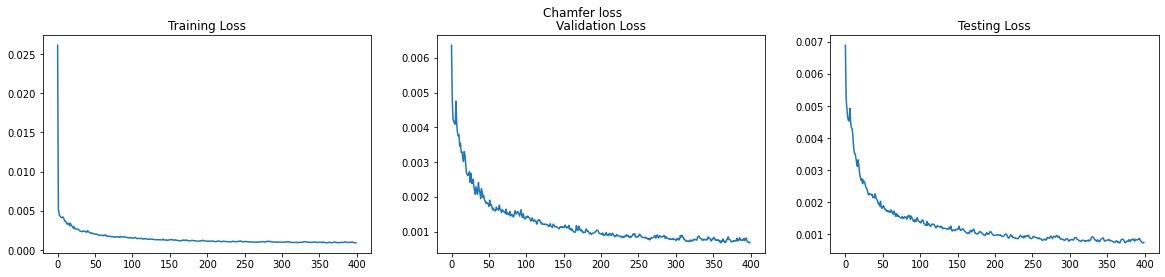

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))

fig.suptitle("Chamfer loss")
axes[0].plot(range(n_train_epochs), train_chamfer_loss, label='Train loss')
axes[0].set_title('Training Loss')
axes[1].plot(range(n_train_epochs), val_chamfer_loss, label='Val loss')
axes[1].set_title('Validation Loss')
axes[2].plot(range(n_train_epochs), test_chamfer_loss, label='Test loss')
axes[2].set_title('Testing Loss')

Text(0.5, 1.0, 'Testing Loss')

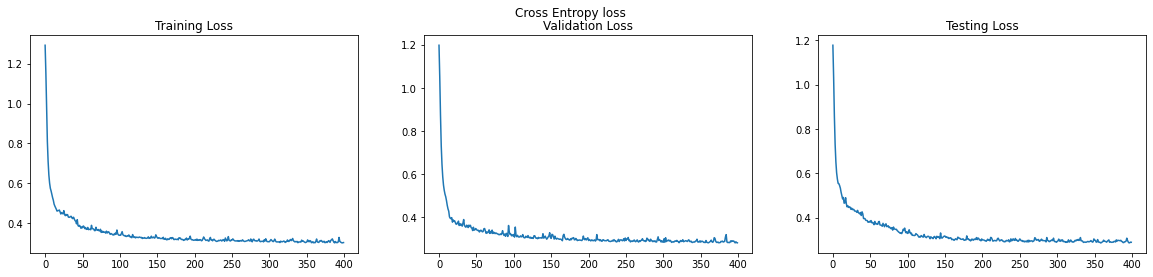

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))

fig.suptitle("Cross Entropy loss")
axes[0].plot(range(n_train_epochs), train_xe_loss, label='Train loss')
axes[0].set_title('Training Loss')
axes[1].plot(range(n_train_epochs), val_xe_loss, label='Val loss')
axes[1].set_title('Validation Loss')
axes[2].plot(range(n_train_epochs), test_xe_loss, label='Test loss')
axes[2].set_title('Testing Loss')

In [13]:
# Load model with best per-validation loss (uncomment when ready)
best_epoch = load_state_dicts(out_file, model=model)
print('per-validation optimal epoch', best_epoch)

per-validation optimal epoch 361


In [20]:
losses

[tensor(0.0025, device='cuda:0'), tensor(0.0017, device='cuda:0')]

In [27]:
# Reconstruct from best model
recons, losses, recon_losses, pred_labels = model.reconstruct(loaders['test'], device=device)
recons = torch.cat(recons, dim=0)
recon_losses = torch.stack(recon_losses)
pred_labels = torch.cat(pred_labels, dim=0).cpu()

In [28]:
_, pred_labels = torch.max(pred_labels, 1)
pred_labels = pred_labels.cpu().numpy()

In [29]:
recon_losses = recon_losses.cpu().numpy()
mean_loss = np.mean(recon_losses)
print('Reconstruction loss: ', mean_loss)

Reconstruction loss:  0.00068179664


Example:  8a67fd47001e52414c350d7ea5fe2a3a


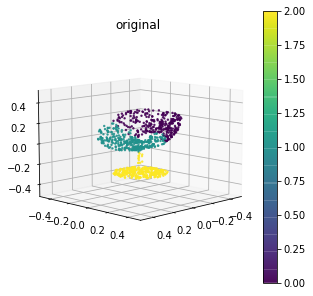

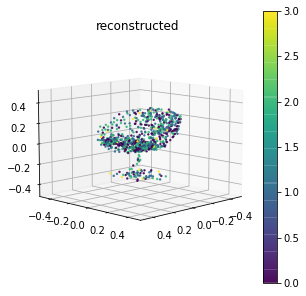

Example:  1e0580f443a9e6d2593ebeeedbff73b


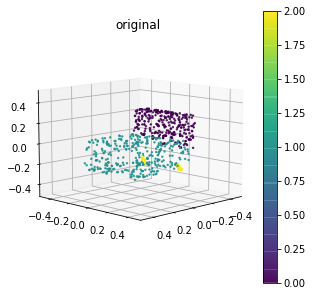

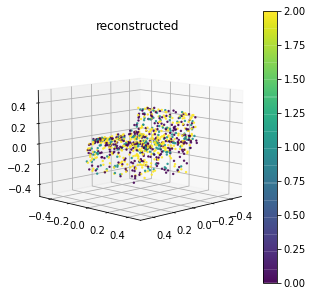

Example:  d3562f992aa405b214b1fd95dbca05


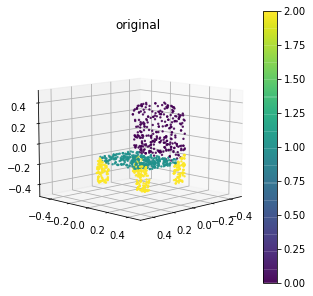

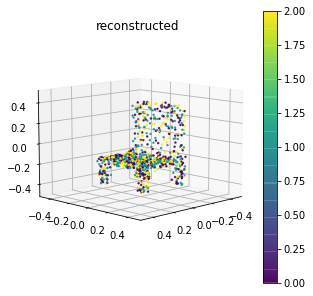

Example:  4e8d8792a3a6390b36b0f2a1430e993a


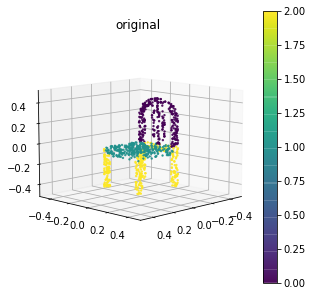

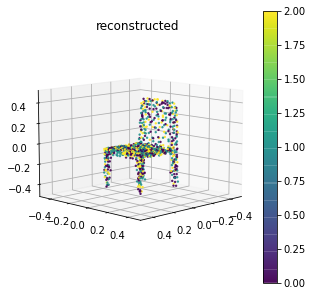

Example:  58479a7b7c157865e68f66efebc71317


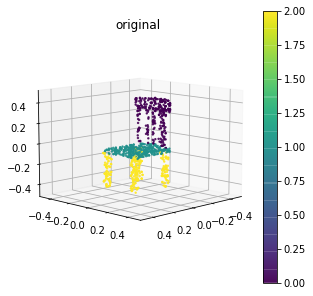

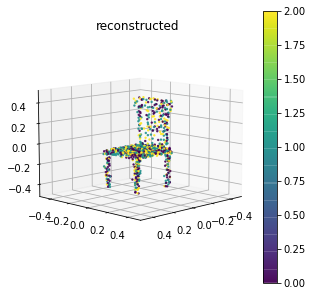

In [30]:
# Students TODO: MAKE your plots and analysis

# 5 examples to visualize per questions (e, f)
examples_to_visualize = ['8a67fd47001e52414c350d7ea5fe2a3a',
                         '1e0580f443a9e6d2593ebeeedbff73b',
                         'd3562f992aa405b214b1fd95dbca05',
                         '4e8d8792a3a6390b36b0f2a1430e993a',
                         '58479a7b7c157865e68f66efebc71317']
# You can (also) use the function for the reconstructions or the part-predictions 
# (for the latter check the kwargs parameter 'c' of matplotlib.
# plot_3d_point_cloud, eg. try plot_3d_point_cloud(loaders['test'].dataset.pointclouds[0])

for example in examples_to_visualize:
    print("Example: ", example)
    index = np.where(loaders['test'].dataset.model_names == example)
    index = np.int(index[0])
    
    orig = plot_3d_point_cloud(loaders['test'].dataset.pointclouds[index], title = 'original', c = loaders['test'].dataset.part_masks[index])
    recon = plot_3d_point_cloud(recons[index].cpu(), title = 'reconstructed', c = pred_labels[index])
    




#model.eval()   # Do not forget this.! We are not training any more (OK, since we do not 
               # have batch-norm, drop-out etc. this is not so important, however it is good standard 
               # practice)

In [31]:
tolerance = 1e-10
accuracy = (np.abs(pred_labels - loaders['test'].dataset.part_masks) < tolerance).mean(axis=1)

In [33]:
accuracy.mean()

0.89779296875

Worst Example:  58479a7b7c157865e68f66efebc71317
Accuracy:  0.5703125


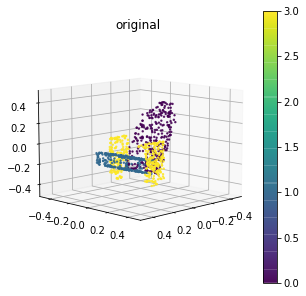

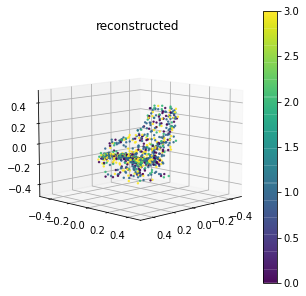

Best Example:  58479a7b7c157865e68f66efebc71317
Accuracy:  0.9921875


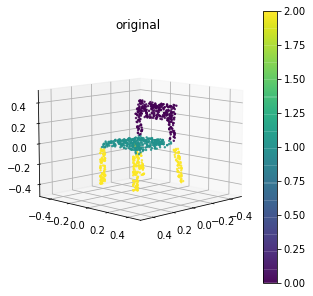

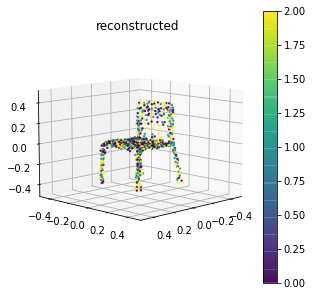

In [132]:
# Best and worst
min_example = accuracy.argmin()
max_example = accuracy.argmax()


print("Worst Example: ", example)
print("Accuracy: ", accuracy.min())

orig = plot_3d_point_cloud(loaders['test'].dataset.pointclouds[min_example], title = 'original',c = loaders['test'].dataset.part_masks[min_example])
recon = plot_3d_point_cloud(recons[min_example].cpu(), title = 'reconstructed', c = pred_labels[min_example])

print("Best Example: ", example)
print("Accuracy: ", accuracy.max())

orig = plot_3d_point_cloud(loaders['test'].dataset.pointclouds[max_example], title = 'original',c = loaders['test'].dataset.part_masks[max_example])
recon = plot_3d_point_cloud(recons[max_example].cpu(), title = 'reconstructed', c = pred_labels[max_example])